# Plastic matrices
This example explores the ability of Connectome Utilities to represent connectivity that is changing over time.

## Structural changes
We begin with structural changes, i.e. the presence or absence of connections between nodes changes.

In [1]:
import numpy
import numpy as np
import pandas
import conntility

from scipy import sparse
from matplotlib import pyplot as plt

StructurallyPlasticMatrix can be initialized in two ways:
1. like a regular ConnectivityMatrix, additionally specifying dicts of points in time when individual edges are switched on or off
2. By explicitly specifying a list of sparse matrices

Here, we demonstrate (1)

In [2]:
base_matrix = sparse.coo_matrix(numpy.random.rand(25, 25) < 0.5)
ncon = base_matrix.nnz

switch_off = {0: numpy.random.choice(ncon, 10, replace=False)} # 10 random connections initially switched off
switch_on = {1: switch_off[0][:5]} # Half of them switched back on in the next time step

M = conntility.StructurallyPlasticMatrix(numpy.random.rand(25, 25) < 0.5, edge_off=switch_off, edge_on=switch_on)

The object can be used just like a ConnectivityMatrix object with all functionality.
It represents the union of all edges.
Indexing it returns the ConnectivityMatrix at the specified point in time, i.e. with certain edges switched off or on

In [3]:
print("""
Overall number of edges: {0}
At time=0: {1}
At time=1: {2}
""".format(M.matrix.nnz, M[0].matrix.nnz, M[1].matrix.nnz))


Overall number of edges: 328
At time=0: 318
At time=1: 323



Initialization option (2)

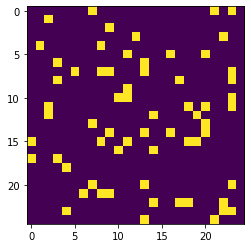

In [4]:
ms = [sparse.coo_matrix(numpy.random.rand(25, 25) < 0.1) for _ in range(10)]
M = conntility.StructurallyPlasticMatrix.from_matrix_stack(ms)

plt.imshow(M[5].array)

Reminder that the base object without indexing represents the union of all edges:

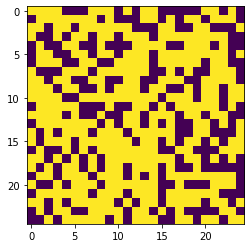

In [5]:
plt.imshow(M.array)

Compared to explicitly storing just a list of ConnectivityMatrices, this object is more efficient in some contexts, because it only stores the change in edges from one point to another.

It offers some utility, such as easy access to the "delta", i.e. the net change from one point to another.

All utility demonstrated below is more efficient than implementations using lists of ConnectivityMatrices if the amount of change is small compared to the overall size of the matrix.

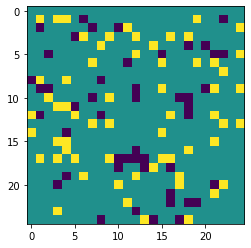

In [6]:
idx_fr = 3; idx_to = 7
a = M[idx_fr]; b = M[idx_to]
delta = M.delta(idx_fr, idx_to)

assert numpy.all((b.array.astype(int) - a.array) == delta.array)

plt.imshow(delta.array)

The change between the union of all edges and the first matrix is accessed by using "-1" as the base

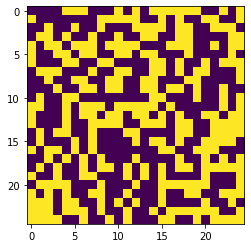

In [7]:
delta = M.delta(-1, 0)

assert numpy.all(M.array + delta.array == M[0].array)
plt.imshow(delta.array)

The number of changes per edge, i.e. how often it is switched on or off:

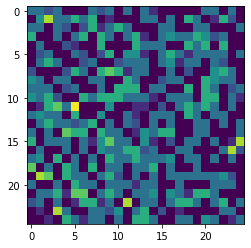

In [8]:
c_total = M.count_changes()
c_on = M.count_changes(count_off=False)
c_off = M.count_changes(count_on=False)

assert numpy.all(c_total.array == (c_on.array + c_off.array))

plt.imshow(c_total.array)

The total number of time steps a given edge is switched on for (i.e. the sum of stack of matrices)

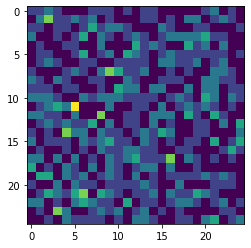

In [9]:
c_count = M.amount_active().array

cmp_count = numpy.dstack([numpy.array(_m.todense()) for _m in ms]).sum(axis=2)

assert numpy.all(c_count == cmp_count)
plt.imshow(c_count)

Something that would be trickier when representing the data as a list of ConnectivityMatrices:
We skip the change ocurring in a given time step.

In [10]:
Mskip = M.skip(4)

A = M[3]
B = Mskip[4] # should be the same, as change happening in step 4 is ignored.
assert numpy.all(A.array == B.array)

## Weight changes

The "TimeDependentMatrix" class represent a connectivity matrix where the locations of edges are fixed, but their weights, or other properties change over time.

To initialize it, we determine the (fixed) row and columns indices. Here, just randomly generated.
Then we build the list of time steps at which the properties are to be sampled as a pandas.Float64Index.

Finally, we build any number of pandas.DataFrame that hold the changing edge properties. One DataFrame per property. The number of columns must be the number of sampled time steps and use the generated index. The length must be equal to the number of connections (and be in the same order as the list of row and column indices). Here, we just randomly generate values.

In [48]:
sz = 100
n_steps = 50

t = pandas.Float64Index(10.0 * numpy.arange(n_steps))
row, col = numpy.nonzero(numpy.random.rand(sz, sz) < 0.1)
rnd_weights_1 = pandas.DataFrame(numpy.random.rand(len(row), n_steps),
                                 columns=t)
rnd_weights_2 = pandas.DataFrame(numpy.random.rand(len(row), n_steps),
                                 columns=t)


Tm = conntility.TimeDependentMatrix(row, col, edge_properties={"rnd1": rnd_weights_1,
                                                               "rnd2": rnd_weights_2}, shape=(sz, sz))

<ipython-input-48-65068de988a3>:4: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  t = pandas.Float64Index(10.0 * numpy.arange(n_steps))
/gpfs/bbp.cscs.ch/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/connectivity.py:968: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert np.all([isinstance(x.columns, pd.Float64Index) for x in edge_properties.values()]),\


We can then access the status of the matrix at any of the sampled time points and use the result like any ConnectivityMatrix.
In principle, the entire functionality demonstrated in the other examples is available.

In [50]:
print(Tm.at_time(400).matrix.sum())
print(Tm.at_time(200).matrix.sum()) # Different values.

500.3866556883874
504.0400299957947


But which of the two random properties we provided is used in this case? By default it is the one that is provided first. 
But we can change that with the .default operation.

In [53]:
print(Tm.at_time(400).matrix.sum())
print(Tm.default("rnd2").at_time(400).matrix.sum()) # Same time, different property
print(Tm.at_time(400).default("rnd2").matrix.sum()) # Does the same

500.3866556883874
508.6806270865665
508.6806270865665
